In [1]:
%load_ext autoreload
%autoreload 1

import json
import os
import pickle
import time
import timeit

import numpy as np

os.environ["DGLBACKEND"] = "pytorch"

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import from_networkx, edge_subgraph
from dgl.nn.pytorch import EdgeWeightNorm
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)
from sklearn.utils import class_weight

from src.calculate_FPR_FNR import calculate_FPR_FNR_with_global
from src.dataset.dataset_info import datasets
import src.models as models
# from src.models import EGAT, EGCN, EGRAPHSAGE, Model
from src.plot_confusion_matrix import plot_confusion_matrix

%aimport src.models

num_epochs = 10
batch_size = 128
learning_rate = 0.001
LAMBD_2 = 0.001

In [2]:
# name = "cic_ton_iot_5_percent"
# name = "cic_ton_iot"
name = "cic_ids_2017_5_percent"
# name = "cic_ids_2017"
# name = "cic_bot_iot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
# name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"

use_node_features = False
node_features_version = 1

using_masking = False
masked_class = 2

multi_class = True

# dataset properties
use_port_in_address = True
generated_ips = False

graph_type = "flow"

sort_timestamp = False

dataset = datasets[name]

dataset_folder = os.path.join("datasets", name)
dataset_folder

'datasets\\cic_ids_2017_5_percent'

In [3]:
g_type = "flow"
    
if multi_class:
    g_type += "__multi_class"
    
if use_node_features:
    g_type += "__n_feats"
    
# if k_fold:
#     g_type += f"__{k_fold}_fold"
    
if use_port_in_address:
    g_type += "__ports"
    
if generated_ips:
    g_type += "__generated_ips"
    
if sort_timestamp:
    g_type += "__sorted"
else:
    g_type += "__unsorted"
    
graphs_folder = os.path.join(dataset_folder, g_type)
graphs_folder

'datasets\\cic_ids_2017_5_percent\\flow__multi_class__ports__unsorted'

In [4]:
number_neighbors = [25, 10]
# number_neighbors = None
num_layers=2
ndim_out = [128, 128]
aggregation="mean"
# aggregation="pool"
# aggregation="lstm"
# aggregation="gcn"
activation=F.relu
dropout=0.2

my_models = [
    # models.Model("e_gcn", models.EGCN, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, residual=False, norm=False),
    # models.Model("e_gcn_res", models.EGCN, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, residual=True, norm=False),
    models.Model("e_graph_sage", models.EGRAPHSAGE, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, residual=False, aggregation=aggregation, num_neighbors=number_neighbors),
    models.Model("e_graph_sage_res", models.EGRAPHSAGE, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, residual=True, aggregation=aggregation, num_neighbors=number_neighbors),
    # models.Model("e_gat", models.EGAT, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, residual=False),
    # models.Model("e_gat_res", models.EGAT, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, residual=True),
]

In [5]:
results_final = {}

results_final["name"] = name
results_final["g_type"] = g_type
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "multi_class": multi_class,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "num_neighbors": number_neighbors,
    "use_node_features": use_node_features,
    "node_features_version": node_features_version,
    "using_masking": using_masking,
    "masked_class_num": masked_class,
    "e_graph_sage_aggregation": aggregation,
    "LAMBD_2": LAMBD_2,
}

results_final["accuracy"] = {}
results_final["f1_score"] = {}
results_final["FPR"] = {}
results_final["FNR"] = {}
results_final["time_elapsed"] = {}
results_final["train_accuracy"] = {}
results_final["train_loss"] = {}
results_final["val_accuracy"] = {}
results_final["val_loss"] = {}
results_final["val_precision"] = {}
results_final["val_recall"] = {}
results_final["val_f1"] = {}
results_final["val_FPR"] = {}
results_final["val_FNR"] = {}

for m in my_models:
    results_final[m.model_name] = {}
    results_final["accuracy"][m.model_name] = []
    results_final["time_elapsed"][m.model_name] = []
    results_final["train_accuracy"][m.model_name] = []
    results_final["train_loss"][m.model_name] = []
    results_final["val_accuracy"][m.model_name] = []
    results_final["val_loss"][m.model_name] = []
    results_final["val_precision"][m.model_name] = []
    results_final["val_recall"][m.model_name] = []
    results_final["val_f1"][m.model_name] = []
    results_final["val_FPR"][m.model_name] = []
    results_final["val_FNR"][m.model_name] = []

results_final

{'name': 'cic_ids_2017_5_percent',
 'g_type': 'flow__multi_class__ports__unsorted',
 'configuration': {'num_epochs': 10,
  'multi_class': True,
  'batch_size': 128,
  'learning_rate': 0.001,
  'num_neighbors': [25, 10],
  'with_centralities': False,
  'use_node_features': False,
  'node_features_version': 1,
  'using_masking': False,
  'masked_class_num': 2,
  'e_graph_sage_aggregation': 'mean',
  'LAMBD_2': 0.001},
 'accuracy': {'e_graph_sage': [], 'e_graph_sage_res': []},
 'f1_score': {},
 'FPR': {},
 'FNR': {},
 'time_elapsed': {'e_graph_sage': [], 'e_graph_sage_res': []},
 'train_accuracy': {'e_graph_sage': [], 'e_graph_sage_res': []},
 'train_loss': {'e_graph_sage': [], 'e_graph_sage_res': []},
 'val_accuracy': {'e_graph_sage': [], 'e_graph_sage_res': []},
 'val_loss': {'e_graph_sage': [], 'e_graph_sage_res': []},
 'val_precision': {'e_graph_sage': [], 'e_graph_sage_res': []},
 'val_recall': {'e_graph_sage': [], 'e_graph_sage_res': []},
 'val_f1': {'e_graph_sage': [], 'e_graph_sag

In [6]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20250114-200752'

In [7]:
results_folder_path = "results"
results_folder_path1 = os.path.join(results_folder_path, name)
results_folder_path2 = os.path.join(results_folder_path1, g_type)
folder_path = os.path.join(results_folder_path2, dtime)
confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
os.makedirs(confusion_matrices_path, exist_ok=True)

In [8]:
labels = ["Normal", "Attack"]
num_classes = 2
if multi_class:
    with open(os.path.join(dataset_folder, "labels_names.pkl"), "rb") as f:
        labels_names = pickle.load(f)
    labels_mapping = labels_names[0]
    # labels = labels_names[1]
    labels = list(labels_mapping.values())
    num_classes = len(labels)
labels, num_classes

([np.str_('BENIGN'),
  np.str_('Bot'),
  np.str_('DDoS'),
  np.str_('DoS GoldenEye'),
  np.str_('DoS Hulk'),
  np.str_('DoS Slowhttptest'),
  np.str_('DoS slowloris'),
  np.str_('FTP-Patator'),
  np.str_('Infiltration'),
  np.str_('PortScan'),
  np.str_('SSH-Patator'),
  np.str_('Web Attack � Brute Force'),
  np.str_('Web Attack � Sql Injection'),
  np.str_('Web Attack � XSS')],
 14)

In [9]:
if using_masking:
    results_final["configuration"]["masked_class_name"] = str(labels[masked_class])

In [10]:
with open(os.path.join(graphs_folder, "training_graph.pkl"), "rb") as f:
    G = pickle.load(f)

In [11]:
with open(os.path.join(graphs_folder, "validation_graph.pkl"), "rb") as f:
    G_val = pickle.load(f)

In [12]:
with open(os.path.join(graphs_folder, "testing_graph.pkl"), "rb") as f:
    G_test = pickle.load(f)

In [13]:
edge_attributes = edge_attrs = ['h', dataset.label_col, dataset.class_num_col]

if use_node_features:
    G = from_networkx(G, edge_attrs=edge_attributes, node_attrs=["n_feats"])
    G_val = from_networkx(G_val, edge_attrs=edge_attributes, node_attrs=["n_feats"])  
    G_test = from_networkx(G_test, edge_attrs=edge_attributes, node_attrs=["n_feats"])  
else:
    G = from_networkx(G,  edge_attrs=edge_attributes)
    G_val = from_networkx(G_val,  edge_attrs=edge_attributes)
    G_test = from_networkx(G_test,  edge_attrs=edge_attributes)

In [14]:
num_features = G.edata['h'].shape[1]
num_features

31

In [15]:
if using_masking:
    # Create masks for edges
    training_mask = G.edata[dataset.class_num_col] != masked_class  # Include all edges except class 3
    # val_mask = G_val.edata[dataset.class_num_col] == masked_class    # Include only edges of class 3 (or other validation logic)
    # test_mask = G_test.edata[dataset.class_num_col] == masked_class   # Include only edges of class 3
    
    G = edge_subgraph(G, training_mask)
    # G_val = edge_subgraph(G_val, val_mask)
    # G_test = edge_subgraph(G_test, test_mask)


In [16]:
if use_node_features:
    # G.ndata["h"] = th.cat([G.ndata["n_feats"], th.ones(G.num_nodes(), num_features)], dim=1)
    G.ndata["h"] = G.ndata["n_feats"]
else:
    G.ndata['h'] = th.ones(G.num_nodes(), num_features)  # noqa: F821
    
ndim_in = G.ndata["h"].shape[-1]

G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, G.ndata['h'].shape[1]))
# G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, ndim_in))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, num_features))

G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)
# G.edata['train_mask'] = training_mask

In [17]:
if multi_class:
    class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(
                                                    G.edata[dataset.class_num_col].cpu().numpy()),
                                                y=G.edata[dataset.class_num_col].cpu().numpy())
else:
    class_weights = class_weight.compute_class_weight('balanced',
                                                    classes=np.unique(
                                                        G.edata[dataset.label_col].cpu().numpy()),
                                                    y=G.edata[dataset.label_col].cpu().numpy())

In [18]:
if using_masking:
    class_weights=np.insert(class_weights, masked_class, 0)

In [19]:
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [20]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [21]:
if multi_class:
    val_labels = G_val.edata[dataset.class_num_col]
else:
    val_labels = G_val.edata[dataset.label_col]

if use_node_features:
    # G_val.ndata["feature"] = th.cat([G_val.ndata["n_feats"], th.ones(G_val.num_nodes(), num_features)], dim=1)
    G_val.ndata["feature"] = G_val.ndata["n_feats"]
else:
    G_val.ndata['feature'] = th.ones(G_val.num_nodes(),  num_features)

G_val.edata['val_mask'] = th.ones(len(G_val.edata['h']), dtype=th.bool)
# G_val.edata['val_mask'] = val_mask

In [22]:
G_val.ndata['feature'] = th.reshape(G_val.ndata['feature'], (G_val.ndata['feature'].shape[0], 1, G_val.ndata['feature'].shape[1]))
G_val.edata['h'] = th.reshape(G_val.edata['h'], (G_val.edata['h'].shape[0], 1, G_val.edata['h'].shape[1]))

In [23]:
if multi_class:
    test_labels = G_test.edata[dataset.class_num_col]
else:
    test_labels = G_test.edata[dataset.label_col]

if use_node_features:
    # G_test.ndata["feature"] = th.cat([G_test.ndata["n_feats"], th.ones(G_test.num_nodes(), num_features)], dim=1)
    G_test.ndata["feature"] = G_test.ndata["n_feats"]
else:
    G_test.ndata['feature'] = th.ones(G_test.num_nodes(),  num_features)

G_test.edata['test_mask'] = th.ones(len(G_test.edata['h']), dtype=th.bool)
# G_test.edata['test_mask'] = test_mask

In [24]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [25]:
def evaluate_model(model:models.Model, graph, actual_labels, loss_fn, results_f, _labels):
    start_time = timeit.default_timer()
    model.trained_model.eval()

    if model.norm:
        edge_weight = th.ones(graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(graph, edge_weight)
        graph.edata['norm_weight'] = norm_edge_weight

    node_features_test = graph.ndata['feature']
    edge_features_test = graph.edata['h']
    
    with th.no_grad():
        test_pred = model.trained_model(graph, node_features_test, edge_features_test)
        
    elapsed = timeit.default_timer() - start_time

    loss = loss_fn(test_pred, actual_labels)
    
    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    if multi_class:
        actual = np.vectorize(labels_names[0].get)(actual_labels)
        test_pred = np.vectorize(labels_names[0].get)(test_pred)
    else:
        actual = ["Normal" if i == 0 else "Attack" for i in actual_labels]
        test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    cr = classification_report(actual, test_pred, digits=4, output_dict=True, zero_division=0)
    cm = confusion_matrix(actual, test_pred, labels=_labels)
    results_fpr_fnr = calculate_FPR_FNR_with_global(cm)
    
    val_acc = cr["accuracy"] * 100
    val_loss = loss.item()
    results_f["val_accuracy"][model.model_name].append(val_acc)
    results_f["val_loss"][model.model_name].append(val_loss)
    results_f["val_precision"][model.model_name].append(cr['weighted avg']['precision'] * 100)
    results_f["val_recall"][model.model_name].append(cr['weighted avg']['recall'] * 100)
    results_f["val_f1"][model.model_name].append(cr['weighted avg']['f1-score'] * 100)
    results_f["val_FPR"][model.model_name].append(results_fpr_fnr["global"]["FPR"])
    results_f["val_FNR"][model.model_name].append(results_fpr_fnr["global"]["FNR"])
    
    return (val_acc, val_loss, elapsed)

In [26]:
def train_model(model: models.Model, graph, _labels):
    node_features = graph.ndata['h']
    edge_features = graph.edata['h']

    edge_label = graph.edata[dataset.class_num_col if multi_class else dataset.label_col]
        
    train_mask = graph.edata['train_mask']

    # model = EGRAPHSAGE(num_features, num_features, 128, F.relu,
    #                    dropout=0.2, num_neighbors=4, residual=residual)

    if model.norm:
        edge_weight = th.ones(graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(graph, edge_weight)
        graph.edata['norm_weight'] = norm_edge_weight

    if model.model_class == models.EGRAPHSAGE:
        model.trained_model = model.model_class(ndim_in, num_features, model.ndim_out, num_layers=model.num_layers, activation=model.activation, aggregation=model.aggregation,
                            dropout=model.dropout, num_neighbors=model.num_neighbors, residual=model.residual, num_class=num_classes)
        model.best_model = model.model_class(ndim_in, num_features, model.ndim_out, num_layers=model.num_layers, activation=model.activation, aggregation=model.aggregation,
                            dropout=model.dropout, num_neighbors=model.num_neighbors, residual=model.residual, num_class=num_classes)  
    elif model.model_class == models.EGCN:
        model.trained_model = model.model_class(ndim_in, num_features, model.ndim_out, num_layers=model.num_layers, activation=model.activation,
                            dropout=model.dropout, residual=model.residual, num_class=num_classes, norm=model.norm)
        model.best_model = model.model_class(ndim_in, num_features, model.ndim_out, num_layers=model.num_layers, activation=model.activation,
                            dropout=model.dropout, residual=model.residual, num_class=num_classes, norm=model.norm)
    else:
        model.trained_model = model.model_class(ndim_in, num_features, model.ndim_out, num_layers=model.num_layers, activation=model.activation,
                            dropout=model.dropout, residual=model.residual, num_class=num_classes)
        model.best_model = model.model_class(ndim_in, num_features, model.ndim_out, num_layers=model.num_layers, activation=model.activation,
                            dropout=model.dropout, residual=model.residual, num_class=num_classes)

    opt = th.optim.Adam(model.trained_model.parameters(), lr = learning_rate, weight_decay=LAMBD_2)
    
    best_acc = 0
    for epoch in range(1, num_epochs):
        model.trained_model.train()
        pred = model.trained_model(graph, node_features, edge_features[train_mask])
        loss = criterion(pred[train_mask], edge_label[train_mask])
        opt.zero_grad()
        loss.backward()
        opt.step()
        if epoch == 1:
            print("================================")
            print("================================")
            print(f"Training Model: {model.model_name}")
            print(f"Edge label shape: {edge_label.shape}")
            print(f"Edge label unique values: {th.unique(edge_label)}")
            print(f"Pred shape: {pred.shape}")
            
        train_acc = compute_accuracy(pred[train_mask], edge_label[train_mask]) * 100
        print(f"Model: {model.model_name} -- Epoch: {epoch} -- Training acc: {train_acc:.2f} -- Training loss: {loss.item():.4f}")
        
        results_final["train_accuracy"][model.model_name].append(train_acc)
        results_final["train_loss"][model.model_name].append(loss.item())
        
        val_acc, val_loss, elapsed = evaluate_model(model, G_val, val_labels, criterion, results_final, _labels)

        print(f"Model: {model.model_name} -- Epoch: {epoch} -- Validation acc: {val_acc:.2f} -- Validation loss: {val_loss:.4f}")
        print("Time for validation: ", str(elapsed) + ' seconds')    
        
        if best_acc < val_acc:
            best_acc = val_acc
            best_model_state = model.trained_model.state_dict().copy()
            
    model.best_model.load_state_dict(best_model_state)
        
    return model

In [27]:
def test_model(model:models.Model, graph, actual_labels, results_f, _labels):
    print("=======================")
    print(f"testing model: {model.model_name}")
    
    start_time = timeit.default_timer()
    model.best_model.eval()
    
    if model.norm:
        edge_weight = th.ones(graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(graph, edge_weight)
        graph.edata['norm_weight'] = norm_edge_weight
    
    node_features_test = graph.ndata['feature']
    edge_features_test = graph.edata['h']
    
    with th.no_grad():
        test_pred = model.best_model(graph, node_features_test, edge_features_test)
        
    elapsed = timeit.default_timer() - start_time
    
    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()
    
    if multi_class:
        actual = np.vectorize(labels_names[0].get)(actual_labels)
        test_pred = np.vectorize(labels_names[0].get)(test_pred)
    else:
        actual = ["Normal" if i == 0 else "Attack" for i in actual_labels]
        test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    cr = classification_report(actual, test_pred, digits=4, output_dict=True, zero_division=0)
    cm = confusion_matrix(actual, test_pred, labels=_labels)
    cm_normalized = confusion_matrix(actual, test_pred, labels=labels, normalize="true")
    results_fpr_fnr = calculate_FPR_FNR_with_global(cm)

    # Log metrics
    results_f[model.model_name]["elapsed"] = elapsed
    results_f[model.model_name]["classification_report"] = cr
    results_f[model.model_name]["results_fpr_fnr"] = results_fpr_fnr
    results_f["accuracy"][model.model_name] = cr["accuracy"] * 100
    results_f["f1_score"][model.model_name] = cr['weighted avg']['f1-score'] * 100
    results_f["FPR"][model.model_name] = results_fpr_fnr["global"]["FPR"]
    results_f["FNR"][model.model_name] = results_fpr_fnr["global"]["FNR"]
    results_f["time_elapsed"][model.model_name] = elapsed

    print(classification_report(actual, test_pred, digits=4, zero_division=0))
    
    return actual, test_pred, cm, cm_normalized


### Training GNN models

In [28]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

In [29]:
%autoreload

Training Model: e_graph_sage
Edge label shape: torch.Size([114416])
Edge label unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
Pred shape: torch.Size([114416, 14])
Model: e_graph_sage -- Epoch: 1 -- Training acc: 0.27 -- Training loss: 2.6780
Model: e_graph_sage -- Epoch: 1 -- Validation acc: 0.34 -- Validation loss: 2.4499
Time for validation:  0.19065880007110536 seconds
Model: e_graph_sage -- Epoch: 2 -- Training acc: 0.66 -- Training loss: 2.5977
Model: e_graph_sage -- Epoch: 2 -- Validation acc: 1.05 -- Validation loss: 2.2915
Time for validation:  0.0983556000282988 seconds
Model: e_graph_sage -- Epoch: 3 -- Training acc: 1.56 -- Training loss: 2.5267
Model: e_graph_sage -- Epoch: 3 -- Validation acc: 2.21 -- Validation loss: 2.2636
Time for validation:  0.13431240001227707 seconds
Model: e_graph_sage -- Epoch: 4 -- Training acc: 3.47 -- Training loss: 2.4718
Model: e_graph_sage -- Epoch: 4 -- Validation acc: 6.22 -- Validation loss: 2.2519
Time fo

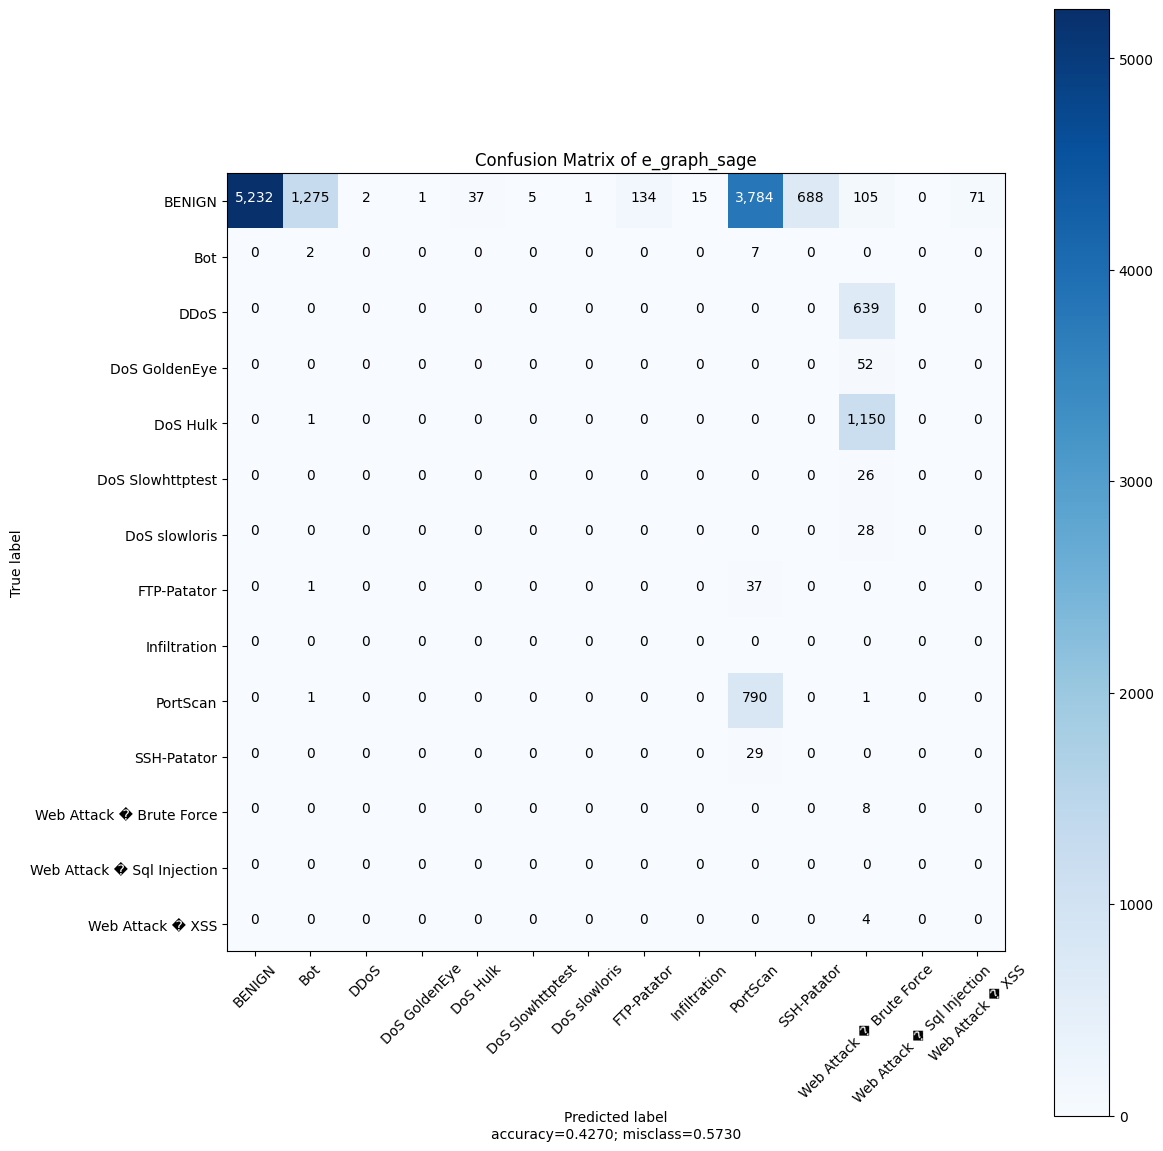

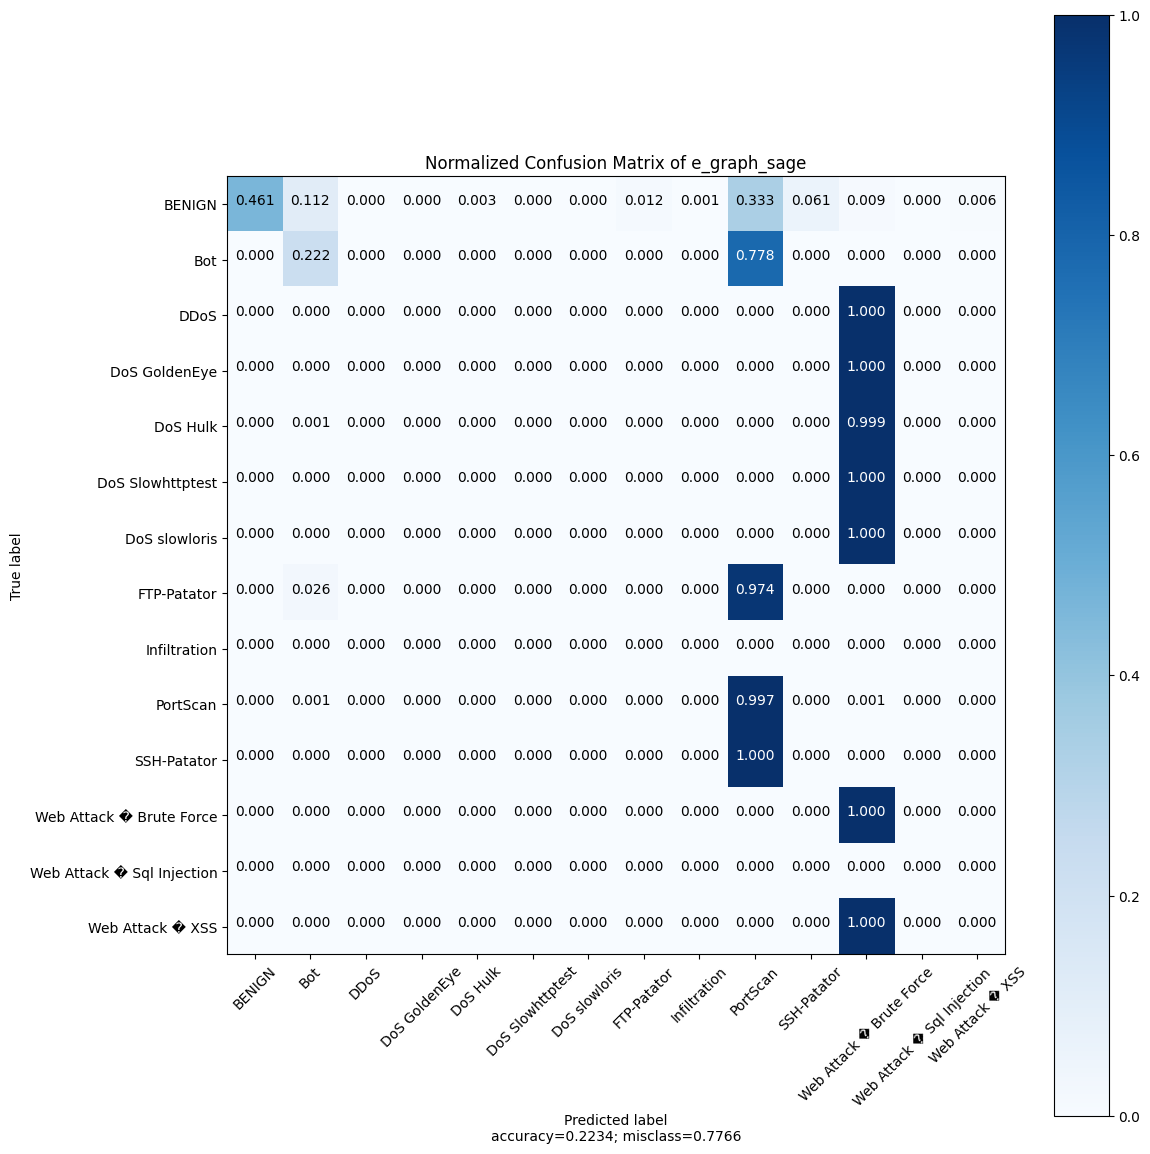

Training Model: e_graph_sage_res
Edge label shape: torch.Size([114416])
Edge label unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
Pred shape: torch.Size([114416, 14])
Model: e_graph_sage_res -- Epoch: 1 -- Training acc: 7.29 -- Training loss: 2.5271
Model: e_graph_sage_res -- Epoch: 1 -- Validation acc: 6.61 -- Validation loss: 2.2341
Time for validation:  0.1703957999125123 seconds
Model: e_graph_sage_res -- Epoch: 2 -- Training acc: 7.34 -- Training loss: 2.4758
Model: e_graph_sage_res -- Epoch: 2 -- Validation acc: 6.61 -- Validation loss: 2.2034
Time for validation:  0.32972630008589476 seconds
Model: e_graph_sage_res -- Epoch: 3 -- Training acc: 7.68 -- Training loss: 2.4236
Model: e_graph_sage_res -- Epoch: 3 -- Validation acc: 8.84 -- Validation loss: 2.1829
Time for validation:  0.11632190004456788 seconds
Model: e_graph_sage_res -- Epoch: 4 -- Training acc: 8.89 -- Training loss: 2.3796
Model: e_graph_sage_res -- Epoch: 4 -- Validation acc: 9.0

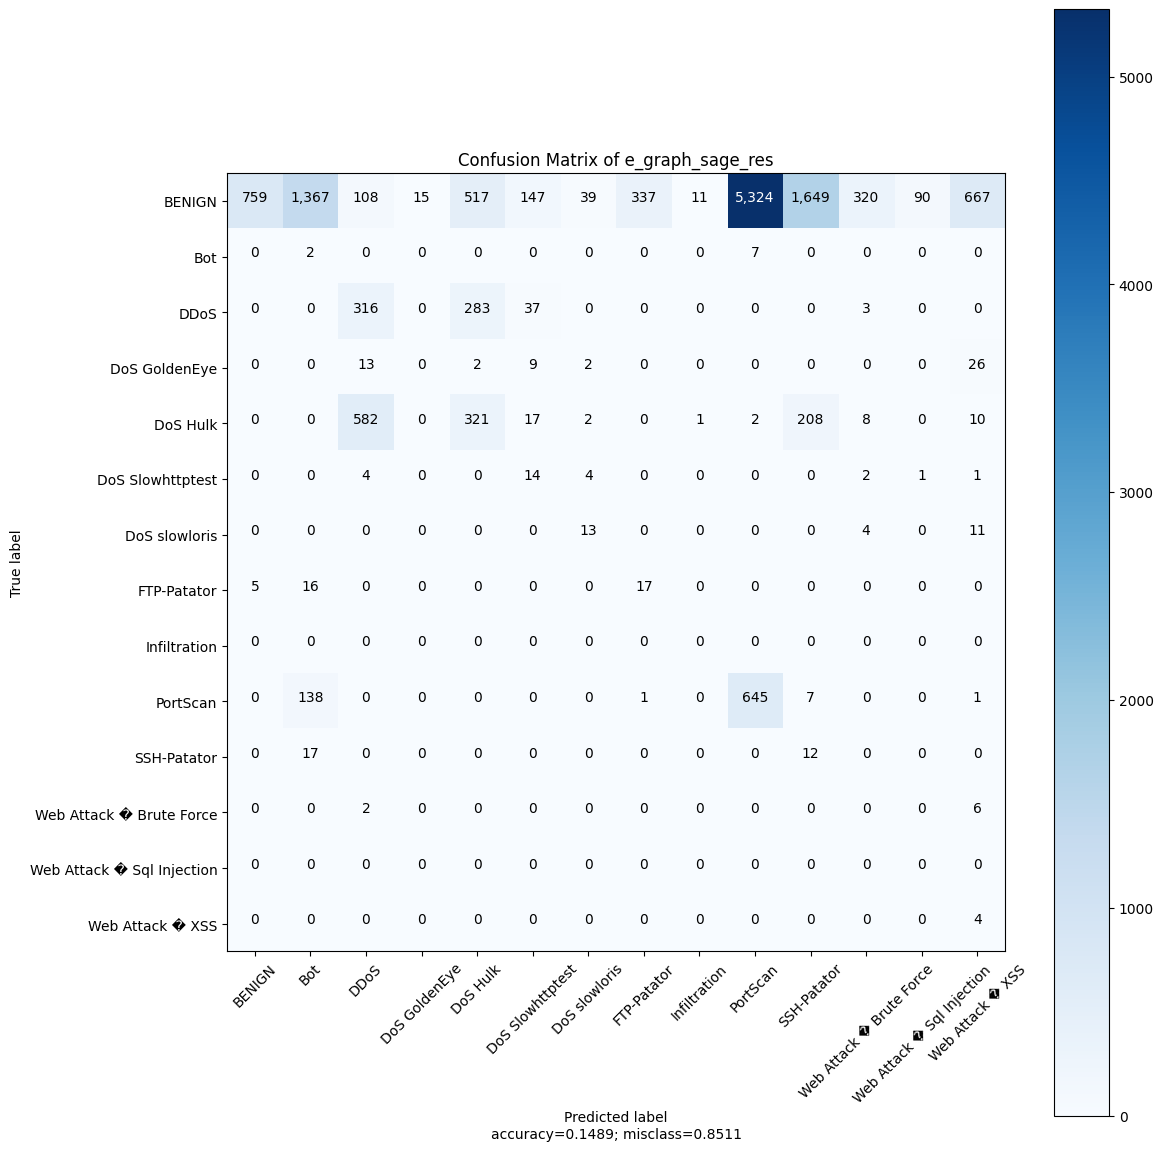

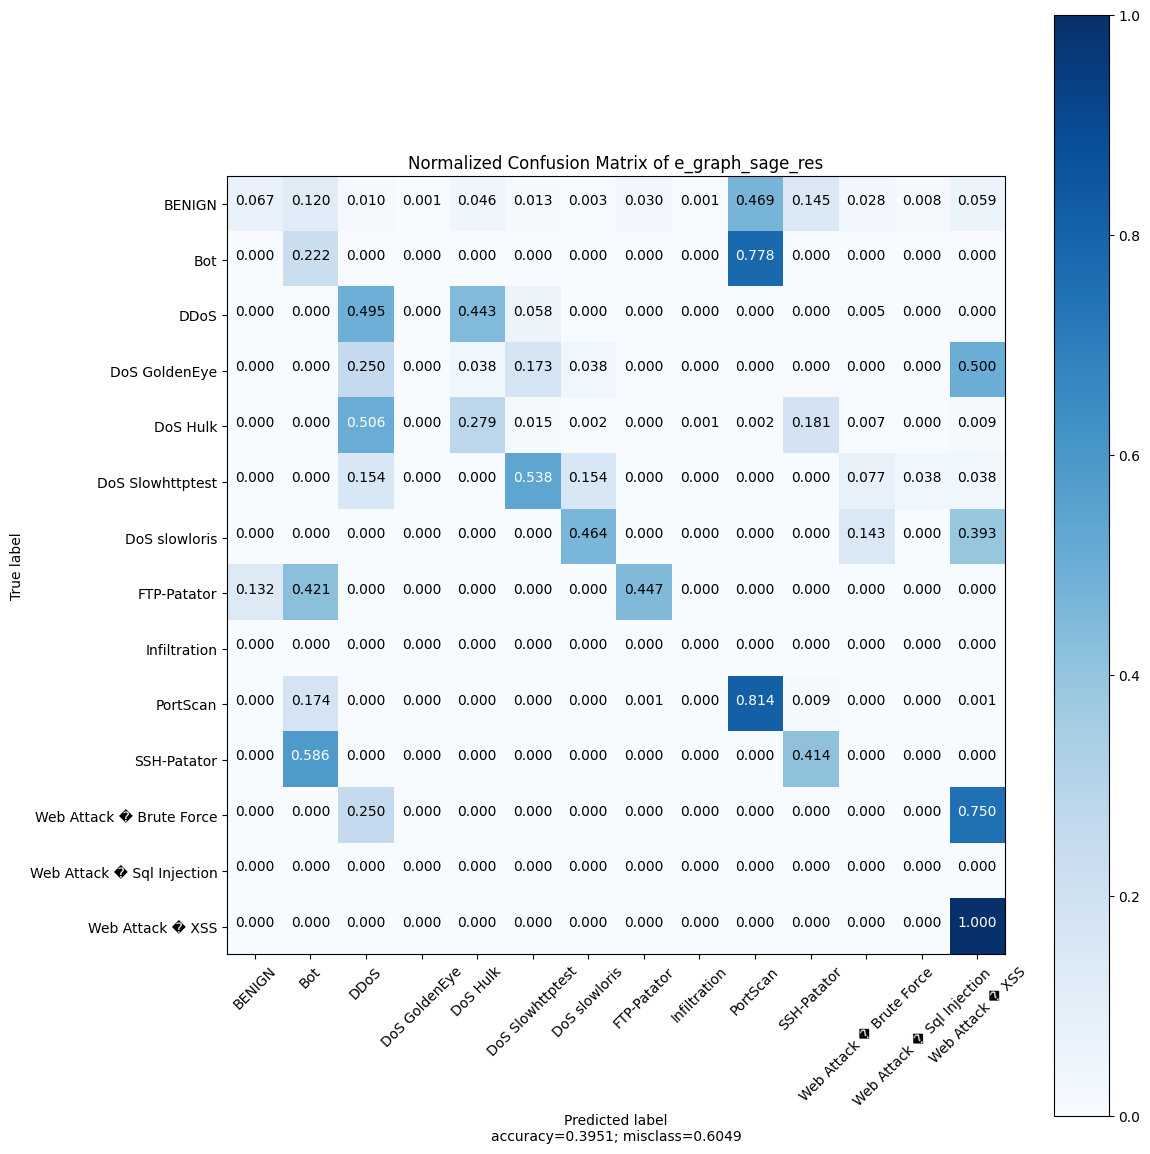

In [30]:
for m in my_models:
    train_model(m, G, labels)
    actual, test_pred, cm, cm_normalized = test_model(m, G_test, test_labels, results_final, labels)
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title=f"Confusion Matrix of {m.model_name}",
                          file_path=f"{confusion_matrices_path}/{m.model_name}.png")
    
    plot_confusion_matrix(cm=cm_normalized,
                          normalize=False,
                          normalized=True,
                          target_names=labels,
                          title=f"Normalized Confusion Matrix of {m.model_name}",
                          file_path=f"{confusion_matrices_path}/{m.model_name}_normalized.png")
    
    with open(os.path.join(folder_path, "actual.json"), "w") as f:
        f.writelines(json.dumps(actual, cls=NumpyEncoder))
        
    with open(os.path.join(folder_path, f"{m.model_name}_pred.json"), "w") as f:
        f.writelines(json.dumps(test_pred, cls=NumpyEncoder))
        
    with open(os.path.join(folder_path, "results.json"), "w") as f:
        f.writelines(json.dumps(results_final, cls=NumpyEncoder))